# Projet RAKUTEN - Partie Texte - ML et Deep

## Chargement et nettoyage des données

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import os as os
import nltk

# On charge le dataset d'entrainement
X_train = pd.read_csv("C:/Users/Morisseau1/DSPP/Donnees/X_train.csv", sep=',',index_col=0)
y_train = pd.read_csv("C:/Users/Morisseau1/DSPP/Donnees/Y_train.csv", sep=',',index_col=0)

# On charge les intitulés de catégorie
categories = pd.read_csv("C:/Users/Morisseau1/DSPP/Donnees/categories.csv",sep=';', index_col=0)

categories



,prdlabelcode
prdtypecode,
10,Livre
40,Jeux-videos
50,Accessoires Jeux
60,Consoles de jeux
1140,figurines 1
1160,cartes jeux
1180,figurines 2
1280,jeux types playmobil
1281,jeux societe


In [5]:
# On crée un dataset global un peu nettoyé
X = pd.concat([X_train, y_train], axis=1)
X["categorie"] = X.prdtypecode.map(categories.prdlabelcode)
X["image"] = "image_" + X.imageid.astype(str) + "_product_" + X.productid.astype(str) + ".jpg"
X["texte"] = X.designation + " " + X.description.fillna('').astype(str)
X.drop(["productid", "imageid", "prdtypecode", "designation", "description"], axis=1, inplace=True)

X.drop_duplicates(subset="texte", inplace=True)

# On enleve les tags htmls dans le texte (titre + description) des annonces
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

X["texte"] = X.texte.apply(strip_tags)

In [3]:
print(X.info())
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83502 entries, 0 to 84915
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   categorie  83502 non-null  object
 1   image      83502 non-null  object
 2   texte      83502 non-null  object
dtypes: object(3)
memory usage: 2.5+ MB
None


,categorie,image,texte
0,Livre,image_1263597046_product_3804725264.jpg,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,"journeaux, magazines",image_1008141237_product_436067568.jpg,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,Accessoires Jeux,image_938777978_product_201115110.jpg,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,jeux types playmobil,image_457047496_product_50418756.jpg,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,Livres 2,image_1077757786_product_278535884.jpg,La Guerre Des Tuques Luc a des idées de grande...


In [26]:
#Chargement des librairies necessaires pour la suite

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Morisseau1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Morisseau1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Morisseau1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Pour la suite, il s'agit de détecter les mots vides afin de les supprimer de notre jeu de données.
La colonne "texte" contient plusieurs langues, notamment le français, l'anglais et l'allemand. Nous devons donc détecter l'ensemble de ces langues dans notre jeu de données.
Par ailleurs, le choix a été fait de passer l'ensemble des descriptions en minuscules.

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize.regexp import RegexpTokenizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

tokenizer = RegexpTokenizer("\w+")

stop_words_fr = stopwords.words("french")
stop_words_en = stopwords.words("english")
stop_words_de = stopwords.words("german")
stop_words = stop_words_fr + stop_words_en + stop_words_de + [str(i) for i in range(0, 100)] + ["x"]
stop_words = {word:0 for word in stop_words} # Optimisation for faster filtering

def stop_words_filtering(string_list):
    return [ w for w in string_list if w not in stop_words ]

In [8]:
#On passe l'ensemble du texte en minuscule
X['texte'] = X['texte'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#print(stop_words)
X.head(10)

,categorie,image,texte
0,Livre,image_1263597046_product_3804725264.jpg,olivia: personalisiertes notizbuch / 150 seite...
1,"journeaux, magazines",image_1008141237_product_436067568.jpg,journal des arts (le) n° 133 du 28/09/2001 - l...
2,Accessoires Jeux,image_938777978_product_201115110.jpg,grand stylet ergonomique bleu gamepad nintendo...
3,jeux types playmobil,image_457047496_product_50418756.jpg,peluche donald - europe - disneyland 2000 (mar...
4,Livres 2,image_1077757786_product_278535884.jpg,la guerre des tuques luc a des idées de grande...
5,"journeaux, magazines",image_393356830_product_5862738.jpg,afrique contemporaine n° 212 hiver 2004 - doss...
6,Livre,image_907794536_product_91920807.jpg,christof e: bildungsprozessen auf der spur
7,papeterie et accessoire papeterie,image_999581347_product_344240059.jpg,conquérant sept cahier couverture polypro 240 ...
8,jeux types playmobil,image_1325918866_product_4239126071.jpg,puzzle scooby-doo avec poster 2x35 pieces
9,meubles jardin,image_1245644185_product_3793572222.jpg,tente pliante v3s5-pro pvc blanc - 3 x 4m50 - ...


In [9]:
#lemmatisation pour avoir uniquement la racine des mots
from nltk.stem import WordNetLemmatizer

lemmatisation = WordNetLemmatizer()
X['texte'] = X['texte'].apply(lambda x: " ".join(lemmatisation.lemmatize(x) for x in x.split()))
X.head(25)


,categorie,image,texte
0,Livre,image_1263597046_product_3804725264.jpg,olivia: personalisiertes notizbuch / 150 seite...
1,"journeaux, magazines",image_1008141237_product_436067568.jpg,journal de art (le) n° 133 du 28/09/2001 - l'a...
2,Accessoires Jeux,image_938777978_product_201115110.jpg,grand stylet ergonomique bleu gamepad nintendo...
3,jeux types playmobil,image_457047496_product_50418756.jpg,peluche donald - europe - disneyland 2000 (mar...
4,Livres 2,image_1077757786_product_278535884.jpg,la guerre de tuques luc a de idées de grandeur...
5,"journeaux, magazines",image_393356830_product_5862738.jpg,afrique contemporaine n° 212 hiver 2004 - doss...
6,Livre,image_907794536_product_91920807.jpg,christof e: bildungsprozessen auf der spur
7,papeterie et accessoire papeterie,image_999581347_product_344240059.jpg,conquérant sept cahier couverture polypro 240 ...
8,jeux types playmobil,image_1325918866_product_4239126071.jpg,puzzle scooby-doo avec poster 2x35 piece
9,meubles jardin,image_1245644185_product_3793572222.jpg,tente pliante v3s5-pro pvc blanc - 3 x 4m50 - ...


Les descriptions de texte ont bien été transformés en liste de mots/chiffres et nettoyés des mots "vides".
A ce stade, la description nous permet donc de réaliser une première phase de modélisation afin de tester différents modèles et comparer leurs performances.

In [10]:

X['texte'] = X['texte'].apply(lambda text: stop_words_filtering(tokenizer.tokenize(text)))

X.head(15)

,categorie,image,texte
0,Livre,image_1263597046_product_3804725264.jpg,"[olivia, personalisiertes, notizbuch, 150, sei..."
1,"journeaux, magazines",image_1008141237_product_436067568.jpg,"[journal, art, 133, 09, 2001, art, marche, sal..."
2,Accessoires Jeux,image_938777978_product_201115110.jpg,"[grand, stylet, ergonomique, bleu, gamepad, ni..."
3,jeux types playmobil,image_457047496_product_50418756.jpg,"[peluche, donald, europe, disneyland, 2000, ma..."
4,Livres 2,image_1077757786_product_278535884.jpg,"[guerre, tuques, luc, idées, grandeur, veut, o..."
5,"journeaux, magazines",image_393356830_product_5862738.jpg,"[afrique, contemporaine, 212, hiver, 2004, dos..."
6,Livre,image_907794536_product_91920807.jpg,"[christof, e, bildungsprozessen, spur]"
7,papeterie et accessoire papeterie,image_999581347_product_344240059.jpg,"[conquérant, sept, cahier, couverture, polypro..."
8,jeux types playmobil,image_1325918866_product_4239126071.jpg,"[puzzle, scooby, doo, poster, 2x35, piece]"
9,meubles jardin,image_1245644185_product_3793572222.jpg,"[tente, pliante, v3s5, pro, pvc, blanc, 4m50, ..."


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.texte, X.categorie, test_size = 0.2)

In [5]:
#X_train = X_train.apply(lambda text: stop_words_filtering(tokenizer.tokenize(text)))
#X_test = X_test.apply(lambda text: stop_words_filtering(tokenizer.tokenize(text)))

In [11]:
len(X_train)

66801

In [12]:
len(X_test)

16701

In [12]:
vectorizer = CountVectorizer(min_df=5)
vectorizer.fit(np.concatenate(pd.concat([X_train, X_test]).array))

CountVectorizer(min_df=5)

In [14]:
len(vectorizer.vocabulary_)

43416

In [13]:
X_train_vect = vectorizer.transform(X_train.str.join(" "))
X_test_vect = vectorizer.transform(X_test.str.join(" "))

# PARTIE 1 : MODELISATION MACHINE LEARNING


### KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_vect, y_train)

KNeighborsClassifier(n_neighbors=6)

In [17]:
y_pred = knn.predict(X_test_vect)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.crosstab(y_test, y_pred, rownames=['classes reelles'], colnames=['classes prédites'])

classes prédites,Accessoires Jeux,Accessoires animaux,"Billard,flechettes,autres",Consoles de jeux,Décoration intérieur,Gadget enfant,Jeux-vidéos,Livre,Livres 2,Matériel enfant,"Nourritures conserves, huiles",accessoires jardin,"accessoires, linges de maison",ameublement intérieur,cartes jeux,equipement baignade jardin,figurines 1,figurines 2,jeux societe,jeux types playmobil,"journeaux, magazines","livres, manges, romans",meubles jardin,package consoles/jeux,papeterie et accessoire papeterie,petits jouets
classes reelles,,,,,,,,,,,,,,,,,,,,,,,,,,
Accessoires Jeux,168,0,0,6,0,1,9,56,3,0,0,1,0,1,0,1,2,1,4,1,3,4,0,51,1,5
Accessoires animaux,2,68,0,0,5,2,5,25,2,9,0,3,0,2,3,8,1,0,0,18,1,6,0,1,1,0
"Billard,flechettes,autres",0,1,99,0,0,1,2,23,1,0,0,0,0,2,2,0,0,1,2,0,0,1,0,0,0,0
Consoles de jeux,4,0,0,131,0,0,2,8,0,1,0,0,0,0,3,0,1,0,3,0,0,0,0,21,0,0
Décoration intérieur,9,17,4,0,590,15,6,81,15,37,7,8,35,37,9,39,16,3,4,20,7,12,13,1,14,4
Gadget enfant,6,5,3,1,19,235,3,60,7,11,0,1,4,6,6,14,10,1,11,33,4,11,1,5,7,2
Jeux-vidéos,31,2,0,6,3,2,297,213,6,2,0,2,0,0,4,4,3,2,64,6,9,13,0,17,2,1
Livre,0,0,3,0,1,0,13,516,20,1,0,0,0,0,3,1,0,0,0,1,15,42,0,0,1,1
Livres 2,0,0,0,1,1,0,14,291,108,5,0,0,0,0,3,1,2,1,3,1,25,64,0,1,0,0


<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

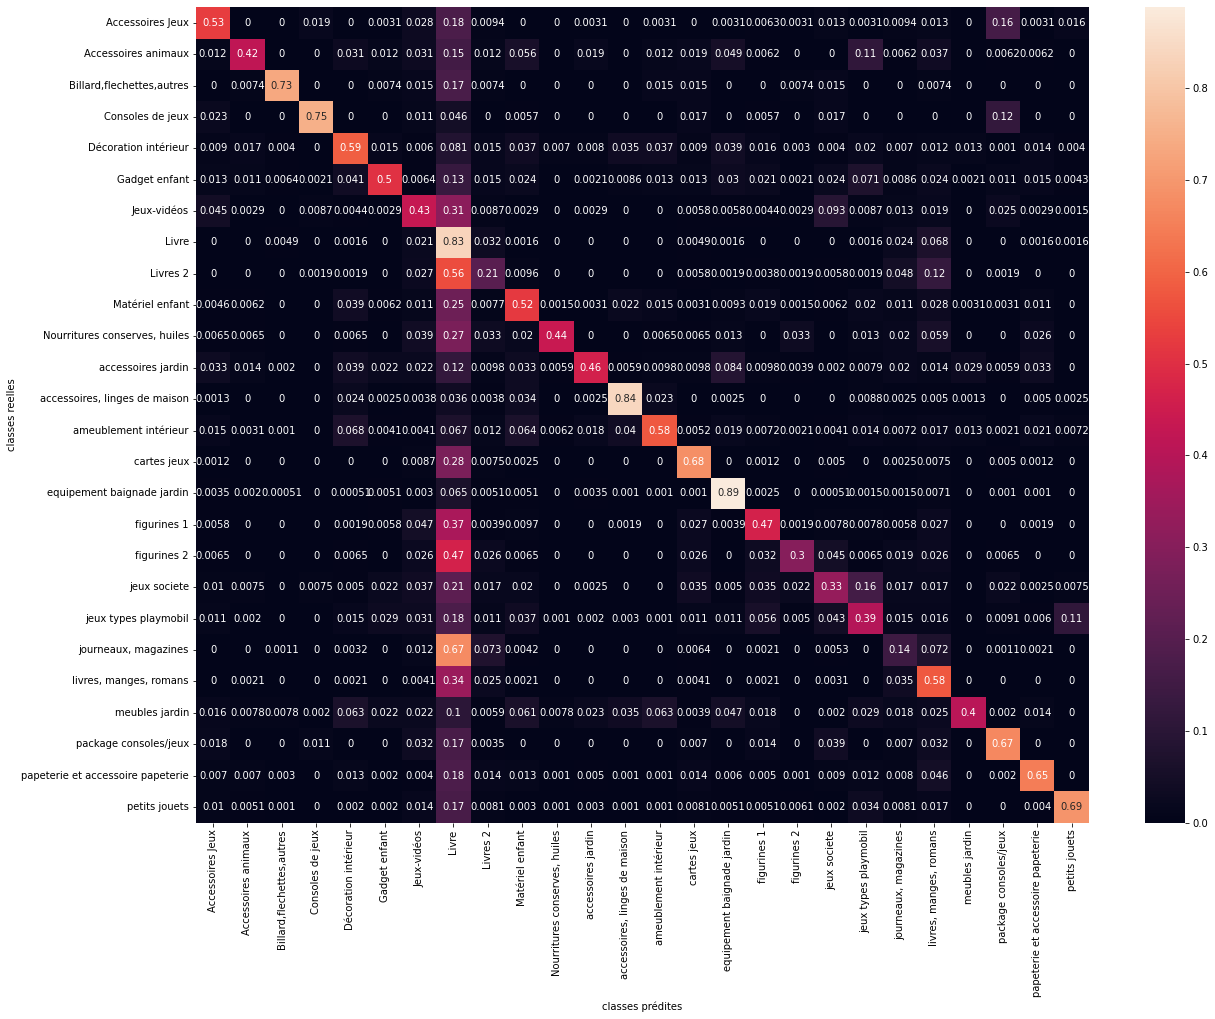

In [19]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.54      0.53      0.53       318
              Accessoires animaux       0.50      0.42      0.46       162
        Billard,flechettes,autres       0.82      0.73      0.77       135
                 Consoles de jeux       0.86      0.75      0.80       174
             Décoration intérieur       0.72      0.59      0.65      1003
                    Gadget enfant       0.69      0.50      0.58       466
                      Jeux-vidéos       0.57      0.43      0.49       689
                            Livre       0.13      0.83      0.23       618
                         Livres 2       0.31      0.21      0.25       521
                  Matériel enfant       0.54      0.52      0.53       647
    Nourritures conserves, huiles       0.74      0.44      0.55       153
               accessoires jardin       0.78      0.46      0.58       509
    accessoires, linges 

In [21]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'Accuracy score: {100*acc:.2f}')

Accuracy score: 57.58


### AUTRE MODELE KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(**{'leaf_size': 20,
 'metric': 'cosine',
 'n_neighbors': 10,
 'p': 1,
 'weights': 'distance'})
knn.fit(X_train_vect, y_train)

KNeighborsClassifier(leaf_size=20, metric='cosine', n_neighbors=10, p=1,
                     weights='distance')

In [25]:
y_pred = knn.predict(X_test_vect)

<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

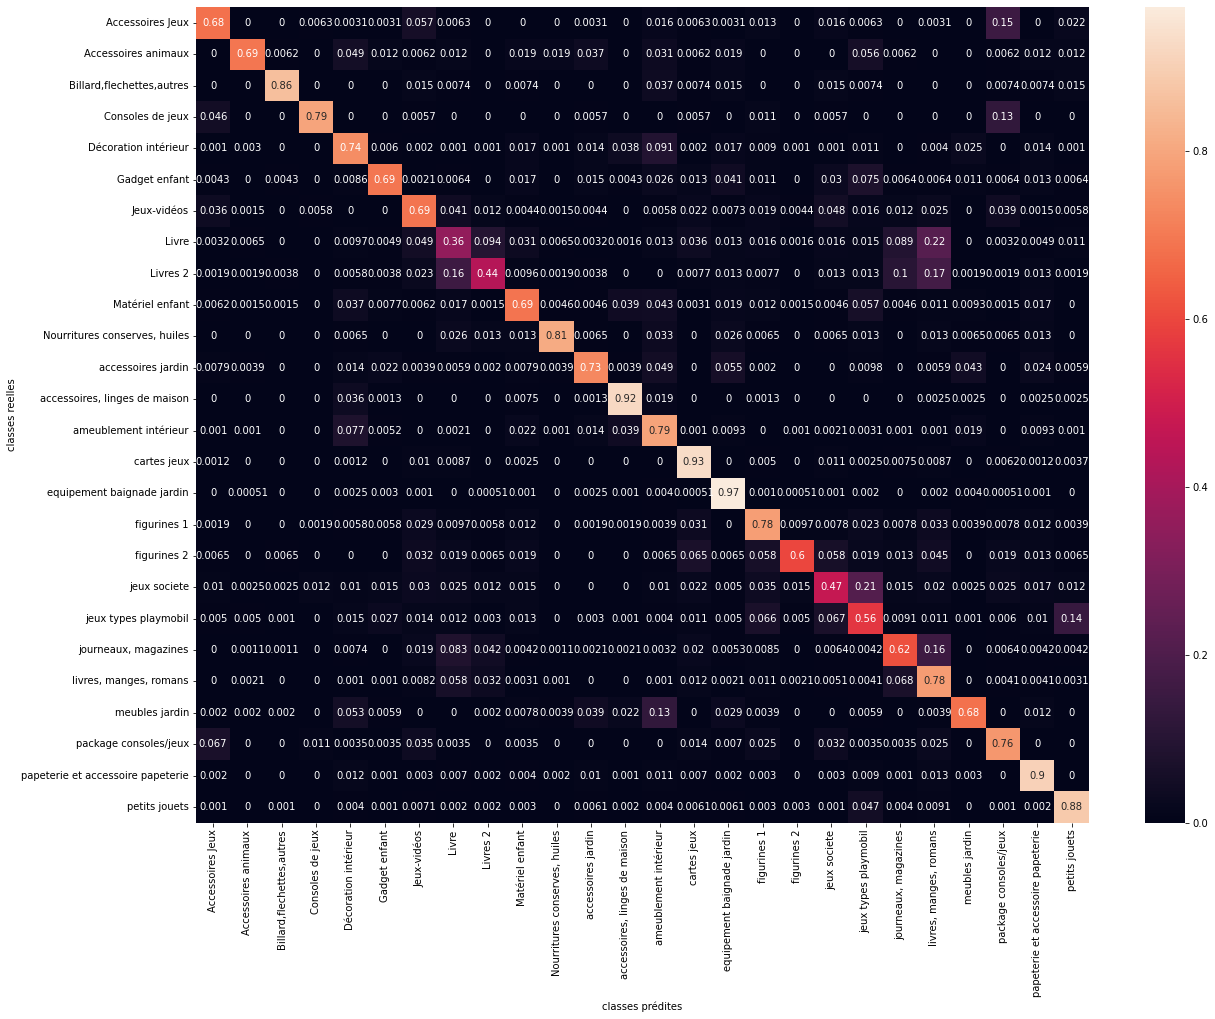

In [26]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.72      0.68      0.70       318
              Accessoires animaux       0.82      0.69      0.75       162
        Billard,flechettes,autres       0.91      0.86      0.88       135
                 Consoles de jeux       0.90      0.79      0.84       174
             Décoration intérieur       0.76      0.74      0.75      1003
                    Gadget enfant       0.79      0.69      0.74       466
                      Jeux-vidéos       0.73      0.69      0.71       689
                            Livre       0.41      0.36      0.38       618
                         Livres 2       0.59      0.44      0.50       521
                  Matériel enfant       0.76      0.69      0.72       647
    Nourritures conserves, huiles       0.85      0.81      0.83       153
               accessoires jardin       0.78      0.73      0.76       509
    accessoires, linges 

In [28]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'Accuracy score: {100*acc:.2f}')

Accuracy score: 75.46


La matrice de confusion en comparaison avec le premier modèle KNN, met en évidence que ce modèle KNN est plus performant.
L'accuracy est de 75,4.

Si l'on se focalise sur les catégories les moins bien prédites dans le premier modèle, ici le rappel est plus elevé :
- 0,62 pour la catégorie "journeaux magazines"

Pour tenter de trouver un meilleur modèle, nous allons executer les codes suivants qui permettra de trouver la meilleure
combinaison de paramètres

In [ ]:
# maintenant, essayer une optimisation des paramètres, avec Grid, toujours sur KNN

In [29]:
from sklearn.model_selection import GridSearchCV


KNN = KNeighborsClassifier(algorithm='auto')
grid_params = {
    'n_neighbors': (1,10, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev','cosine'),
}

In [30]:
gs = GridSearchCV(estimator=KNN, param_grid=grid_params, verbose = 3, scoring = 'accuracy',cv = 3,n_jobs = -1)

In [31]:
resultats = gs.fit(X_train_vect, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python

[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.588 total time=  49.0s
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.588 total time= 1.0min
[CV 2/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.592 total time=  41.0s
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.388 total time=10.0min
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.532 total time=10.0min
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=1, p=1, weights=uniform;, score=0.707 total time=  49.2s
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=1, p=2, weights=uniform;, score=0.707 total time=  50.4s
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.731 total time= 1.1min
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=10, p=2, weights=uniform;, score=0.731 

[CV 3/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.538 total time= 9.9min
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=distance;, score=0.451 total time=10.2min
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.588 total time=  40.9s
[CV 3/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.589 total time=  41.2s
[CV 2/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.592 total time=  39.0s
[CV 1/3] END leaf_size=20, metric=chebyshev, n_neighbors=1, p=1, weights=uniform;, score=nan total time=   0.1s
[CV 2/3] END leaf_size=20, metric=chebyshev, n_neighbors=1, p=1, weights=uniform;, score=nan total time=   0.1s
[CV 3/3] END leaf_size=20, metric=chebyshev, n_neighbors=1, p=1, weights=uniform;, score=nan total time=   0.1s
[CV 1/3] END leaf_size=20, metric=chebyshev, n_neighbors=1, p=1, weights=distance;, score=

[CV 2/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.538 total time= 9.7min
[CV 3/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.385 total time=10.2min
[CV 2/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.538 total time=10.5min
[CV 1/3] END leaf_size=40, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.588 total time=  41.8s
[CV 3/3] END leaf_size=40, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.589 total time=  40.0s
[CV 2/3] END leaf_size=40, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.592 total time=  43.3s
[CV 1/3] END leaf_size=40, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.388 total time=10.1min
[CV 3/3] END leaf_size=40, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.538 total time= 9.8min
[CV 2/3] END leaf_size=40, metric=cosine, n_neighbors=1, p=2, weights=distance;, sco

[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.532 total time=10.1min
[CV 2/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=uniform;, score=0.519 total time= 1.0min
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.545 total time=  53.5s
[CV 3/3] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.545 total time=  49.3s
[CV 1/3] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.532 total time=10.0min
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=1, p=1, weights=distance;, score=0.707 total time=  49.1s
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=1, p=2, weights=distance;, score=0.707 total time=  50.3s
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=distance;, score=0.743 total time= 1.1min
[CV 3/3] END leaf_size=20, metric=cosine, n_neighbors=10, p=2, weights=distance;, scor

In [40]:
import joblib

#save your model or results
joblib.dump(gs, 'model_file_name.pkl')


['model_file_name.pkl']

In [42]:

#load your model for further usage
test = joblib.load("model_file_name.pkl")
resultats.best_score_
resultats.best_params_

{'leaf_size': 20,
 'metric': 'cosine',
 'n_neighbors': 10,
 'p': 1,
 'weights': 'distance'}

In [35]:
y_pred = resultats.predict(X_test_vect)

<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

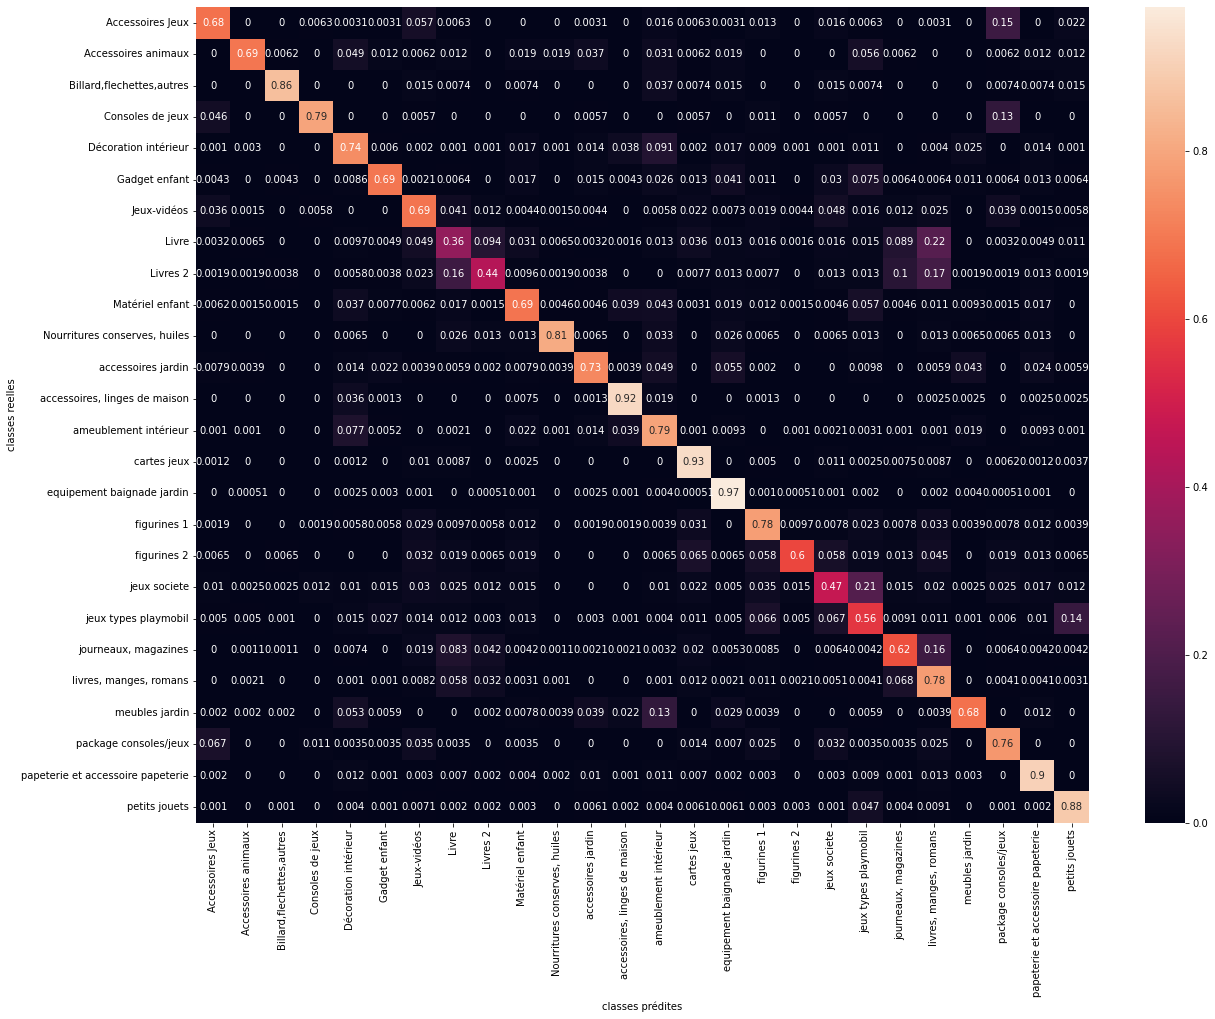

In [36]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.72      0.68      0.70       318
              Accessoires animaux       0.82      0.69      0.75       162
        Billard,flechettes,autres       0.91      0.86      0.88       135
                 Consoles de jeux       0.90      0.79      0.84       174
             Décoration intérieur       0.76      0.74      0.75      1003
                    Gadget enfant       0.79      0.69      0.74       466
                      Jeux-vidéos       0.73      0.69      0.71       689
                            Livre       0.41      0.36      0.38       618
                         Livres 2       0.59      0.44      0.50       521
                  Matériel enfant       0.76      0.69      0.72       647
    Nourritures conserves, huiles       0.85      0.81      0.83       153
               accessoires jardin       0.78      0.73      0.76       509
    accessoires, linges 

In [38]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f'Accuracy score: {100*acc:.2f}')

Accuracy score: 75.46


In [39]:
resultats.best_score_
resultats.best_params_

{'leaf_size': 20,
 'metric': 'cosine',
 'n_neighbors': 10,
 'p': 1,
 'weights': 'distance'}

### REGRESSION LOGISTIQUE (Modèle "naïf")

Dans un premier temps nous allons appliquer un modèle de regression logistique à nos données.
La construction d un premier modèle na¨f nous permettra par la suite le comparer à des modèle avec des paramètres défini
(par validation croisée ou autre)

In [14]:
#Classification / apprentissage supervisé.
from sklearn.linear_model import LogisticRegression

#creation du classifieur de regression logistique avec les paramètres par défauts et construction du modèle
#sur les données d'entrainement
clf_reglog = LogisticRegression(C=1.0, max_iter=1000)
clf_reglog.fit(X_train_vect, y_train)

#prédictions
reglog_y_pred=clf_reglog.predict(X_test_vect)

<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

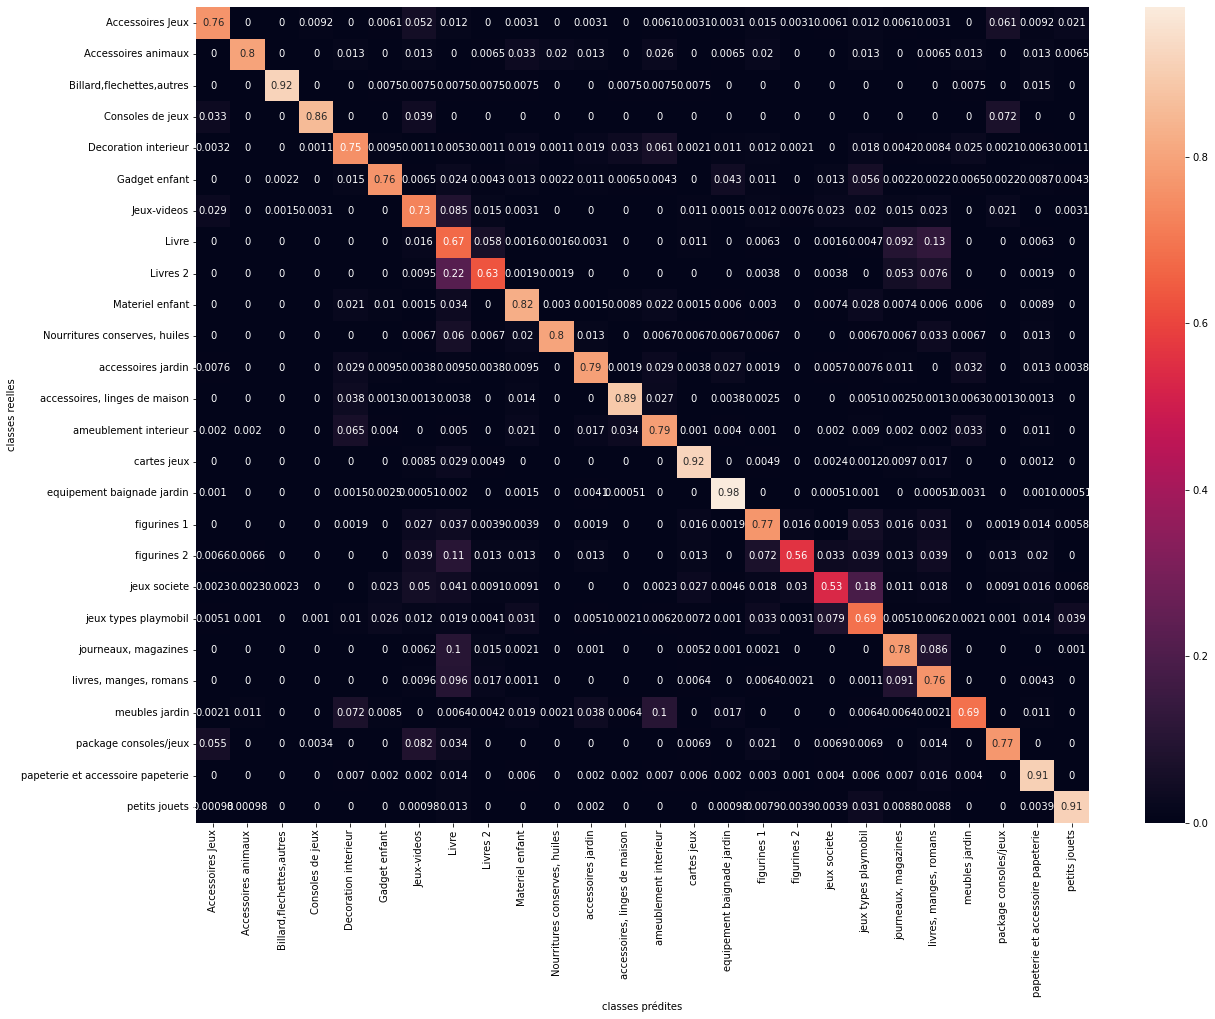

In [15]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, reglog_y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, reglog_y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.80      0.76      0.78       327
              Accessoires animaux       0.92      0.80      0.85       153
        Billard,flechettes,autres       0.98      0.92      0.95       134
                 Consoles de jeux       0.95      0.86      0.90       180
             Decoration interieur       0.79      0.75      0.77       948
                    Gadget enfant       0.82      0.76      0.79       462
                      Jeux-videos       0.75      0.73      0.74       655
                            Livre       0.43      0.67      0.53       638
                         Livres 2       0.76      0.63      0.69       527
                  Materiel enfant       0.80      0.82      0.81       672
    Nourritures conserves, huiles       0.92      0.80      0.86       150
               accessoires jardin       0.83      0.79      0.81       525
    accessoires, linges 

Accuracy = 0.80

### REGRESSION LOGISTIQUE : Recherche d'un meilleur modèle à l'aide d'hyperparamètres et d'une validation croisée

Nous cherchons ici à améliorer notre premier modèle de classification par régression logstique en faisant varier les hyperparamètres et à l'aide d'une validation croisée.L'objectif étant d'améliorer l'accuracy
Il y a également une autre piste pour améliorer nos prédictions : Affiner les libellées des catégories. En effet certaines catégories semblent similaires : "Livre1" et "Livre2" par exemple. "Figurine1" et "Figurine2" Mais par manque de temps, nous ne creuserons pas cette piste

In [47]:

#Recherche d'un meilleur modèle de regression logistique en faisant
#varier un ensemble de paramètres


parametres_LR = {
    "C": [0.01, 0.1, 1, 10, 100], 
    "solver": [
        'newton-cg',
        'lbfgs',
        'liblinear'
    ]
}

In [49]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV


grid_LR = GridSearchCV(estimator=KNN, param_grid=grid_params, verbose = 3, scoring = 'accuracy',n_jobs = -1)

In [50]:
#Entrainement de grid_LR sur les données d'entrainement

grille_train = grid_LR.fit(X_train_vect,y_train)

#Temps d'execution lent --> Voir solution pour optimiser le temps de traitement car impact l'analyse
#et l'avancement

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 4/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.552 total time= 7.1min
[CV 5/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.605 total time=  38.6s
[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.608 total time=  30.5s
[CV 4/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.404 total time= 6.9min
[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=uniform;, score=0.536 total time=  41.6s
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.562 total time=  42.4s
[CV 1/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.570 total time= 6.7min
[CV 4/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.552 total time= 6.8min
[CV 1/5] END leaf_s

[CV 1/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.570 total time= 7.1min
[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.608 total time=  37.8s
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.604 total time=  30.6s
[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.417 total time= 6.9min
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=uniform;, score=0.532 total time=  41.9s
[CV 1/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.561 total time=  42.2s
[CV 5/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.560 total time=  32.9s
[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.558 total time= 6.7min
[CV 1/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;

[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.554 total time= 7.0min
[CV 4/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.552 total time= 6.7min
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=distance;, score=0.472 total time= 6.9min
[CV 5/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.556 total time= 6.9min
[CV 2/5] END leaf_size=20, metric=cosine, n_neighbors=1, p=1, weights=distance;, score=0.720 total time=  31.3s
[CV 1/5] END leaf_size=20, metric=cosine, n_neighbors=1, p=2, weights=uniform;, score=0.712 total time=  33.1s
[CV 2/5] END leaf_size=20, metric=cosine, n_neighbors=1, p=2, weights=distance;, score=0.720 total time=  35.6s
[CV 3/5] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.743 total time=  42.4s
[CV 4/5] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=distance;, score=0.753

/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python3.8/site-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/home/humbert/Desktop/Datascientist/notebook/venv/lib/python

In [51]:
print("Best: %f using %s" % (grille_train.best_score_, grille_train.best_params_))

Best: 0.754330 using {'leaf_size': 20, 'metric': 'cosine', 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}


In [52]:
from time import time
time()

1657405207.9548893

[CV 3/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.558 total time= 7.0min
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.604 total time=  42.1s
[CV 1/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=uniform;, score=0.408 total time= 6.9min
[CV 4/5] END leaf_size=20, metric=minkowski, n_neighbors=10, p=1, weights=distance;, score=0.468 total time= 6.9min
[CV 2/5] END leaf_size=20, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.554 total time= 6.6min
[CV 5/5] END leaf_size=20, metric=cosine, n_neighbors=1, p=2, weights=uniform;, score=0.714 total time=  33.9s
[CV 1/5] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.741 total time=  42.2s
[CV 2/5] END leaf_size=20, metric=cosine, n_neighbors=10, p=1, weights=distance;, score=0.757 total time=  41.9s
[CV 4/5] END leaf_size=20, metric=cosine, n_neighbors=10, p=2, weights=uniform;, score=0.

[CV 4/5] END leaf_size=1, metric=cosine, n_neighbors=1, p=2, weights=uniform;, score=0.717 total time=  33.7s
[CV 4/5] END leaf_size=1, metric=cosine, n_neighbors=1, p=2, weights=distance;, score=0.717 total time=  37.0s
[CV 1/5] END leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=distance;, score=0.755 total time=  43.7s
[CV 1/5] END leaf_size=1, metric=cosine, n_neighbors=10, p=2, weights=uniform;, score=0.741 total time=  49.9s
[CV 5/5] END leaf_size=1, metric=cosine, n_neighbors=10, p=2, weights=distance;, score=0.751 total time=  52.3s
[CV 3/5] END leaf_size=1, metric=cosine, n_neighbors=1, p=1, weights=distance;, score=0.715 total time=  48.8s
[CV 2/5] END leaf_size=1, metric=cosine, n_neighbors=1, p=2, weights=distance;, score=0.720 total time=  33.4s
[CV 3/5] END leaf_size=1, metric=cosine, n_neighbors=1, p=2, weights=distance;, score=0.715 total time=  37.0s
[CV 5/5] END leaf_size=1, metric=cosine, n_neighbors=10, p=1, weights=uniform;, score=0.739 total time=  44.5s


[CV 1/5] END leaf_size=1, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.570 total time= 6.7min
[CV 4/5] END leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=uniform;, score=0.601 total time=  36.7s
[CV 5/5] END leaf_size=1, metric=minkowski, n_neighbors=1, p=2, weights=distance;, score=0.605 total time=  32.8s
[CV 1/5] END leaf_size=1, metric=minkowski, n_neighbors=10, p=1, weights=distance;, score=0.473 total time= 7.0min
[CV 4/5] END leaf_size=1, metric=minkowski, n_neighbors=10, p=2, weights=uniform;, score=0.530 total time=  46.9s
[CV 3/5] END leaf_size=1, metric=minkowski, n_neighbors=10, p=2, weights=distance;, score=0.564 total time=  43.8s
[CV 2/5] END leaf_size=1, metric=minkowski, n_neighbors=1, p=1, weights=uniform;, score=0.554 total time= 6.7min
[CV 5/5] END leaf_size=1, metric=minkowski, n_neighbors=1, p=1, weights=distance;, score=0.556 total time= 7.1min
[CV 5/5] END leaf_size=1, metric=cosine, n_neighbors=10, p=2, weights=uniform;, score=0.

In [55]:
import joblib

#save your model or results
joblib.dump(grille_train, 'regression_cv.pkl')

['regression_cv.pkl']

In [56]:
y_pred = grille_train.predict(X_test_vect)

<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

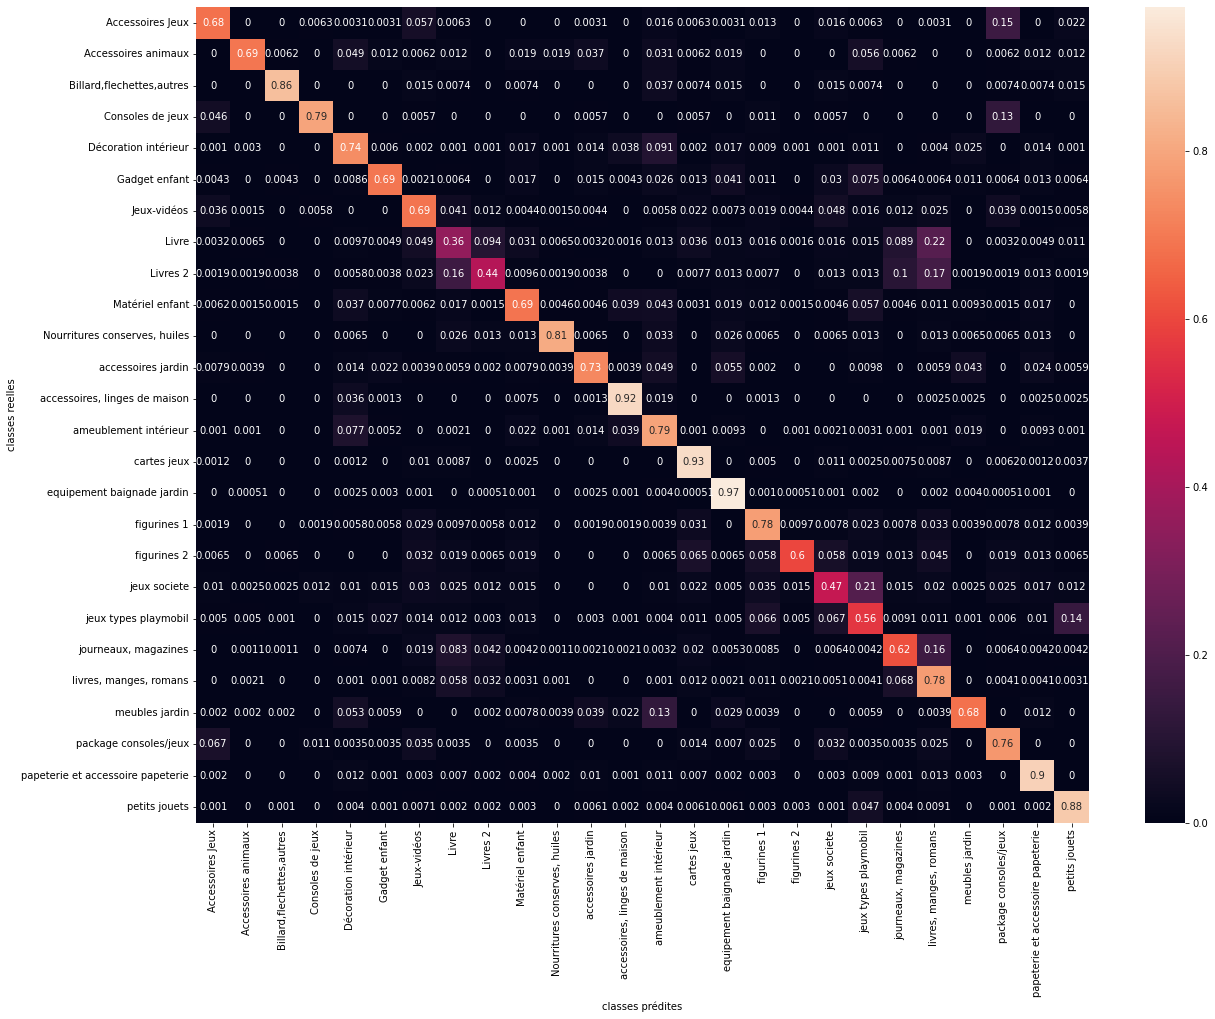

In [57]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.72      0.68      0.70       318
              Accessoires animaux       0.82      0.69      0.75       162
        Billard,flechettes,autres       0.91      0.86      0.88       135
                 Consoles de jeux       0.90      0.79      0.84       174
             Décoration intérieur       0.76      0.74      0.75      1003
                    Gadget enfant       0.79      0.69      0.74       466
                      Jeux-vidéos       0.73      0.69      0.71       689
                            Livre       0.41      0.36      0.38       618
                         Livres 2       0.59      0.44      0.50       521
                  Matériel enfant       0.76      0.69      0.72       647
    Nourritures conserves, huiles       0.85      0.81      0.83       153
               accessoires jardin       0.78      0.73      0.76       509
    accessoires, linges 

###  SVC (Modèle naïf)

In [59]:
from sklearn.svm import SVC

In [60]:
clf_svc = SVC()
clf_svc.fit(X_train_vect, y_train)

SVC()

In [61]:
svc_y_pred = clf_svc.predict(X_test_vect)

<AxesSubplot:xlabel='classes prédites', ylabel='classes reelles'>

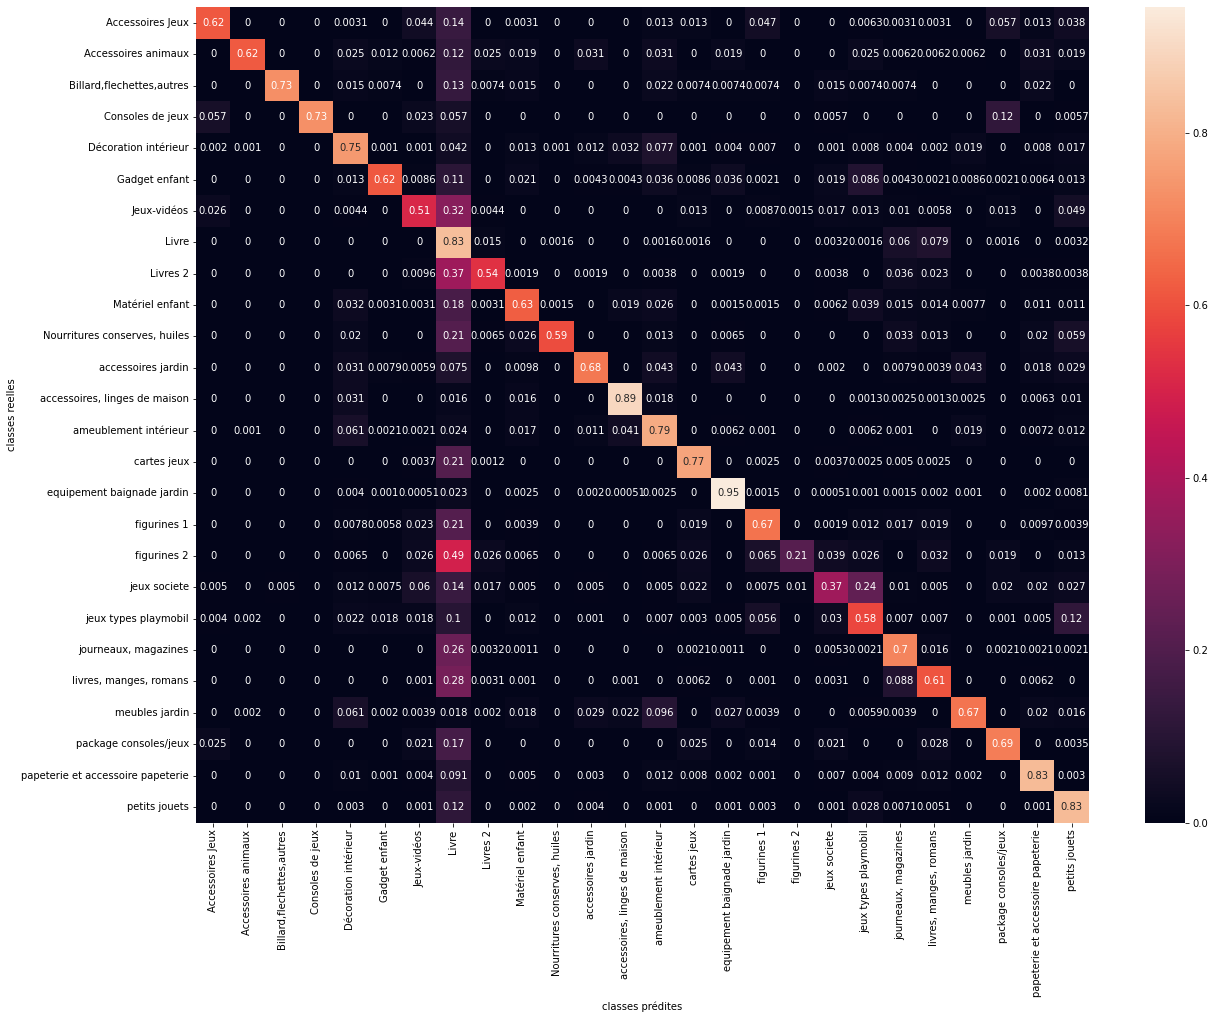

In [62]:
plt.figure(figsize=(20, 15))
cross = pd.crosstab(y_test, svc_y_pred, rownames=['classes reelles'], colnames=['classes prédites'], normalize='index')
sns.heatmap(cross, annot=True)

In [63]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                 Accessoires Jeux       0.72      0.68      0.70       318
              Accessoires animaux       0.82      0.69      0.75       162
        Billard,flechettes,autres       0.91      0.86      0.88       135
                 Consoles de jeux       0.90      0.79      0.84       174
             Décoration intérieur       0.76      0.74      0.75      1003
                    Gadget enfant       0.79      0.69      0.74       466
                      Jeux-vidéos       0.73      0.69      0.71       689
                            Livre       0.41      0.36      0.38       618
                         Livres 2       0.59      0.44      0.50       521
                  Matériel enfant       0.76      0.69      0.72       647
    Nourritures conserves, huiles       0.85      0.81      0.83       153
               accessoires jardin       0.78      0.73      0.76       509
    accessoires, linges 

## Meilleur modèle Texte

La famille des modèle de regression logistique semble être la famille de modèle donnant les résultats les plus satisfaisants.
Cependant nous allons tester d'autres modèle de Deep Learning nous permettant de choisi le meilleur modèle de classification
multimodal pour la partie texte.

# ANNEXE

Code non-executé (temps d'execution mobilie temps machine)

### SVC : Recherche d'un meilleur modèle par validation croisée


In [66]:
parametres_SVC = {
    "C":[0.01,0.1,1,10,100], 
    'kernel':['rbf','linear', 'poly'], 
    'gamma':[0.001, 0.1, 0.5]
}
grid_SVC = model_selection.GridSearchCV(estimator=clf_svc, param_grid=parametres_SVC, n_jobs = -1)

grille_train_SVC = grid_SVC.fit(X_train_vect,y_train)

print("Best: %f using %s" % (grille_train_SVC.best_score_, grille_train_SVC.best_params_))

Best: 0.783147 using {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
